In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import gc
import re
import pickle
import itertools
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [2]:
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.style.use('bmh')

In [3]:
df= pd.read_csv('unbalaced_20_80_dataset.csv')

## Dataset overview

In [5]:
df.head()

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1739476,172.31.69.25-18.219.193.20-80-37882-6,18.219.193.20,37882,172.31.69.25,80,6,16/02/2018 11:27:29 PM,8660,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,230.946882,8660.000000,0.000000,8660.0,8660.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,32,32,115.473441,115.473441,0.0,0.0,0.000,0.000000,0.000000,0,0,0,0,1,0,0,0,1.0,0.000000,0.00,0.000000,0,0,0,0,0,0,1,0,1,0,-1,225,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,1822666,172.31.69.28-18.219.9.1-80-63287-6,172.31.69.28,80,18.219.9.1,63287,6,22/02/2018 12:13:52 AM,5829,4,3,935.0,298.0,935.0,0.0,233.75,467.5,298.0,0.0,99.333333,172.050380,211528.564076,1200.892091,971.500000,2104.124973,5260.0,7.0,5822.0,1940.666667,3119.411857,5541.0,46.0,5540.0,2770.0,3521.391770,5260.0,280.0,0,0,0,0,92,72,686.224052,514.668039,0.0,935.0,154.125,332.306415,110427.553571,0,1,0,0,0,0,1,1,0.0,176.142857,233.75,99.333333,0,0,0,0,0,0,4,935,3,298,-1,32768,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,905739,172.31.69.28-52.14.136.135-80-63095-6,52.14.136.135,63095,172.31.69.28,80,6,22/02/2018 12:14:02 AM,3396,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,588.928151,3396.000000,0.000000,3396.0,3396.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,20,20,294.464075,294.464075,0.0,0.0,0.000,0.000000,0.000000,0,0,0,0,1,0,0,0,1.0,0.000000,0.00,0.000000,0,0,0,0,0,0,1,0,1,0,-1,32738,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,1143064,172.31.69.28-18.216.200.189-80-52341-6,18.216.200.189,52341,172.31.69.28,80,6,22/02/2018 12:28:04 AM,2390,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,836.820084,2390.000000,0.000000,2390.0,2390.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,20,20,418.410042,418.410042,0.0,0.0,0.000,0.000000,0.000000,0,0,0,0,1,0,0,0,1.0,0.000000,0.00,0.000000,0,0,0,0,0,0,1,0,1,0,-1,32738,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,1934016,172.31.69.28-18.218.55.126-80-57459-6,172.31.69.28,80,18.218.55.126,57459,6,22/02/2018 12:19:45 AM,17362,4,3,935.0,314.0,935.0,0.0,233.75,467.5,314.0,0.0,104.666667,181.287985,71938.716738,403.179357,2893.666667,6770.577661,16711.0,7.0,17355.0,5785.000000,9779.680414,17077.0,38.0,17074.0,8537.0,11559.781659,16711.0,363.0,0,0,0,0,92,72,230.388204,172.791153,0.0,935.0,156.125,333.342568,111117.267857,0,1,0,0,0,0,1,1,0.0,178.428571,233.75,104.666667,0,0,0,0,0,0,4,935,3,314,-1,32768,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [6]:
df.describe()

,Unnamed: 0,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.586821e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7616509.0,7616509.0,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7616509.0,7616509.0,7616509.0,7616509.0,7616509.0,7616509.0,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06,7.616509e+06
mean,3.518141e+06,4.171610e+04,1.030737e+04,9.066993e+00,1.168721e+07,1.314120e+01,6.606282e+00,6.304985e+02,5.230745e+03,2.196190e+02,1.186438e+01,5.794405e+01,8.231711e+01,3.571852e+02,2.843344e+01,1.150348e+02,1.310117e+02,inf,inf,2.225967e+06,1.134660e+06,5.318438e+06,1.728327e+06,1.107273e+07,2.488425e+06,1.164599e+06,4.816895e+06,1.780307e+06,8.424175e+06,1.019672e+06,1.080149e+06,3.146269e+06,3.505666e+05,4.797342e-02,3.698939e-03,0.0,0.0,1.725039e+02,1.406306e+02,2.624238e+04,6.952079e+03,1.201686e+01,4.082965e+02,8.191579e+01,1.272005e+02,4.466151e+04,1.436222e-02,9.514057e-02,1.556248e-01,3.071168e-01,3.425924e-01,3.207939e-02,2.849297e-02,1.827361e-01,6.238387e-01,9.467660e+01,5.794405e+01,1.150348e+02,0.0,0.0,0.0,0.0,0.0,0.0,1.314120e+01,6.304985e+02,6.606282e+00,5.230745e+03,4.007476e+03,1.003863e+04,9.369142e+00,1.242835e+01,2.221028e+05,1.138543e+05,3.337165e+05,1.455388e+05,4.130530e+06,1.662807e+05,4.268601e+06,3.975926e+06
std,2.325547e+06,2.326642e+04,2.013310e+04,5.087024e+00,3.066261e+07,1.009401e+03,3.239508e+02,3.153876e+04,6.971802e+05,3.273044e+02,2.411128e+01,7.212265e+01,1.384465e+02,5.177774e+02,5.191029e+01,1.684583e+02,2.062547e+02,NaN,NaN,1.044042e+07,3.904521e+06,1.529950e+07,1.034646e+07,3.048820e+07,1.061671e+07,4.396200e+06,1.493230e+07,1.043396e+07,2.678820e+07,4.858117e+06,3.989200e+06,1.112311e+07,4.233794e+06,2.137100e-01,6.070632e-02,0.0,0.0,9.191150e+03,6.480673e+03,1.996141e+05,6.019581e+04,2.151600e+01,5.421595e+02,1.050468e+02,1.687648e+02,2.288450e+05,1.189788e-01,2.934090e-01,3.624993e-01,4.612983e-01,4.745765e-01,1.762110e-01,1.663765e-01,3.864500e-01,1.188193e+00,1.093802e+02,7.212265e+01,1.684583e+02,0.0,0.0,0.0,0.0,0.0,0.0,1.009401e+03,3.153876e+04,3.239508e+02,6.971802e+05,9.577351e+03,2.115614e+04,9.834211e+02,8.506153e+00,2.970946e+06,1.810069e+06,3.936927e+06,2.498422e+06,1.419110e+07,1.751645e+06,1.44

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7616509 entries, 0 to 7616508
Data columns (total 85 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Flow ID            object 
 2   Src IP             object 
 3   Src Port           int64  
 4   Dst IP             object 
 5   Dst Port           int64  
 6   Protocol           int64  
 7   Timestamp          object 
 8   Flow Duration      int64  
 9   Tot Fwd Pkts       int64  
 10  Tot Bwd Pkts       int64  
 11  TotLen Fwd Pkts    float64
 12  TotLen Bwd Pkts    float64
 13  Fwd Pkt Len Max    float64
 14  Fwd Pkt Len Min    float64
 15  Fwd Pkt Len Mean   float64
 16  Fwd Pkt Len Std    float64
 17  Bwd Pkt Len Max    float64
 18  Bwd Pkt Len Min    float64
 19  Bwd Pkt Len Mean   float64
 20  Bwd Pkt Len Std    float64
 21  Flow Byts/s        float64
 22  Flow Pkts/s        float64
 23  Flow IAT Mean      float64
 24  Flow IAT Std       float64
 25  Flow IAT Max      

## Dataset downcasting

In [9]:
def downcast_df_int_columns(df):
    list_of_columns = list(df.select_dtypes(include=["int32", "int64"]).columns)
        
    if len(list_of_columns)>=1:
        max_string_length = max([len(col) for col in list_of_columns]) # finds max string length for better status printing
        print("downcasting integers for:", list_of_columns, "\n")
        
        for col in list_of_columns:
            print("reduced memory usage for:  ", col.ljust(max_string_length+2)[:max_string_length+2],
                  "from", str(round(df[col].memory_usage(deep=True)*1e-6,2)).rjust(8), "to", end=" ")
            df[col] = pd.to_numeric(df[col], downcast="integer")
            print(str(round(df[col].memory_usage(deep=True)*1e-6,2)).rjust(8))
    else:
        print("no columns to downcast")
    
    gc.collect()

In [10]:
def downcast_df_float_columns(df):
    list_of_columns = list(df.select_dtypes(include=["float64"]).columns)
        
    if len(list_of_columns)>=1:
        max_string_length = max([len(col) for col in list_of_columns]) # finds max string length for better status printing
        print("downcasting float for:", list_of_columns, "\n")
        
        for col in list_of_columns:
            print("reduced memory usage for:  ", col.ljust(max_string_length+2)[:max_string_length+2],
                  "from", str(round(df[col].memory_usage(deep=True)*1e-6,2)).rjust(8), "to", end=" ")
            df[col] = pd.to_numeric(df[col], downcast="float")
            print(str(round(df[col].memory_usage(deep=True)*1e-6,2)).rjust(8))
    else:
        print("no columns to downcast")
    
    gc.collect()

In [11]:
def downcast_df(df):
    downcast_df_int_columns(df)
    downcast_df_float_columns(df)

In [12]:
downcast_df(df)

downcasting integers for: ['Unnamed: 0', 'Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min'] 

reduced memory usage for:   Unnamed: 0          from    60.93 to    30.47
reduced memory usage for:   Src Port            from    60.93 to    30.47
reduced memory usage for:   Dst Port            from    60.93 to    30.47
reduced memory usage for:   Protocol            from    60.93 to     7.62
reduced memory usage for:   Flow Duration       from    60.93 to   

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7616509 entries, 0 to 7616508
Data columns (total 85 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int32  
 1   Flow ID            object 
 2   Src IP             object 
 3   Src Port           int32  
 4   Dst IP             object 
 5   Dst Port           int32  
 6   Protocol           int8   
 7   Timestamp          object 
 8   Flow Duration      int32  
 9   Tot Fwd Pkts       int32  
 10  Tot Bwd Pkts       int32  
 11  TotLen Fwd Pkts    float32
 12  TotLen Bwd Pkts    float32
 13  Fwd Pkt Len Max    float32
 14  Fwd Pkt Len Min    float32
 15  Fwd Pkt Len Mean   float32
 16  Fwd Pkt Len Std    float32
 17  Bwd Pkt Len Max    float32
 18  Bwd Pkt Len Min    float32
 19  Bwd Pkt Len Mean   float32
 20  Bwd Pkt Len Std    float32
 21  Flow Byts/s        float32
 22  Flow Pkts/s        float32
 23  Flow IAT Mean      float32
 24  Flow IAT Std       float32
 25  Flow IAT Max      

In [14]:
'''with open('unbalanced.pkl', 'wb') as f:
    pickle.dump(df, f)'''

In [3]:
with open('unbalanced.pkl', 'rb') as f:
    df= pickle.load(f)

## Data exploration

In [4]:
def prep_df(df):
    del_col= set()
    
    df['Flow Byts/s'].replace(np.inf, np.nan, inplace=True)
    df['Flow Pkts/s'].replace(np.inf, np.nan, inplace=True)
    m1= df['Flow Byts/s'].mean()
    m2= df['Flow Pkts/s'].mean()
    df['Flow Byts/s'].fillna(value=m1, inplace=True)
    df['Flow Pkts/s'].fillna(value=m2, inplace=True)
    df['Timestamp']= pd.to_datetime(df['Timestamp'])
    
    for col in df.columns:
        freq= df[col].value_counts(normalize=True).values[0]
        if df[col].nunique()<=1 or freq>=0.95:
            del_col.add(col)
    df.drop(columns=del_col, inplace=True)

In [5]:
prep_df(df)

In [6]:
print("Columns and their uniques (%)")
max_string_length = max([len(col) for col in list(df.columns)])
for col in df.columns:
    print(f"{col} :", 
          str(df[col].nunique()).rjust(max_string_length-len(col)+6), 
          str(round(100*df[col].nunique()/df.shape[0], 5)).rjust(10))

Columns and their uniques (%)
Unnamed: 0 :       6553320   86.04099
Flow ID :          4715999   61.91812
Src IP :             36760    0.48264
Src Port :           64849    0.85143
Dst IP :             34321    0.45061
Dst Port :           59091    0.77583
Protocol :               3      4e-05
Timestamp :          77598    1.01881
Flow Duration :    2722954   35.75068
Tot Fwd Pkts :        2501    0.03284
Tot Bwd Pkts :        2854    0.03747
TotLen Fwd Pkts :    14820    0.19458
TotLen Bwd Pkts :    60045    0.78835
Fwd Pkt Len Max :     3431    0.04505
Fwd Pkt Len Min :      479    0.00629
Fwd Pkt Len Mean :   71726    0.94172
Fwd Pkt Len Std :   205534    2.69853
Bwd Pkt Len Max :     3787    0.04972
Bwd Pkt Len Min :      444    0.00583
Bwd Pkt Len Mean :  137246    1.80195
Bwd Pkt Len Std :   237429    3.11729
Flow Byts/s :      3432485   45.06638
Flow Pkts/s :      3011950   39.54502
Flow IAT Mean :    2933691   38.51753
Flow IAT Std :     3411313   44.78841
Flow IAT Max :     1

In [7]:
df.head()

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1739476,172.31.69.25-18.219.193.20-80-37882-6,18.219.193.20,37882,172.31.69.25,80,6,2018-02-16 23:27:29,8660,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00000,230.946884,8660.000000,0.000000,8660.0,8660.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,32,32,115.473442,115.473442,0.0,0.0,0.000,0.000000,0.000000,0,0,0,1,0,1.0,0.000000,0.00,0.000000,1,0,1,0,-1,225,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,1822666,172.31.69.28-18.219.9.1-80-63287-6,172.31.69.28,80,18.219.9.1,63287,6,2018-02-22 00:13:52,5829,4,3,935.0,298.0,935.0,0.0,233.75,467.5,298.0,0.0,99.333336,172.050385,211528.56250,1200.892090,971.500000,2104.125000,5260.0,7.0,5822.0,1940.666626,3119.411865,5541.0,46.0,5540.0,2770.0,3521.391846,5260.0,280.0,92,72,686.224060,514.668030,0.0,935.0,154.125,332.306427,110427.554688,1,0,0,0,1,0.0,176.142853,233.75,99.333336,4,935,3,298,-1,32768,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,905739,172.31.69.28-52.14.136.135-80-63095-6,52.14.136.135,63095,172.31.69.28,80,6,2018-02-22 00:14:02,3396,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00000,588.928162,3396.000000,0.000000,3396.0,3396.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,20,20,294.464081,294.464081,0.0,0.0,0.000,0.000000,0.000000,0,0,0,1,0,1.0,0.000000,0.00,0.000000,1,0,1,0,-1,32738,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,1143064,172.31.69.28-18.216.200.189-80-52341-6,18.216.200.189,52341,172.31.69.28,80,6,2018-02-22 00:28:04,2390,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00000,836.820068,2390.000000,0.000000,2390.0,2390.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,20,20,418.410034,418.410034,0.0,0.0,0.000,0.000000,0.000000,0,0,0,1,0,1.0,0.000000,0.00,0.000000,1,0,1,0,-1,32738,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,1934016,172.31.69.28-18.218.55.126-80-57459-6,172.31.69.28,80,18.218.55.126,57459,6,2018-02-22 00:19:45,17362,4,3,935.0,314.0,935.0,0.0,233.75,467.5,314.0,0.0,104.666664,181.287979,71938.71875,403.179352,2893.666748,6770.577637,16711.0,7.0,17355.0,5785.000000,9779.680664,17077.0,38.0,17074.0,8537.0,11559.781250,16711.0,363.0,92,72,230.388199,172.791153,0.0,935.0,156.125,333.342560,111117.265625,1,0,0,0,1,0.0,178.428574,233.75,104.666664,4,935,3,314,-1,32768,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [8]:
df.shape

(7616509, 72)

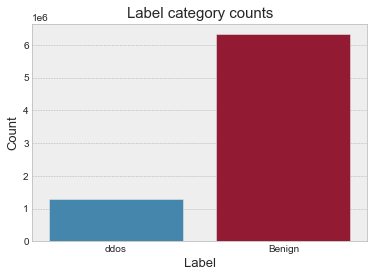

In [9]:
_= sns.countplot(x=df['Label'])
_.axes.set_title("Label category counts",fontsize=15)
_.set_xlabel("Label",fontsize=13)
_.set_ylabel("Count",fontsize=13)
_.tick_params(labelsize=10)
plt.show()

In [10]:
time= pd.crosstab(index=df['Timestamp'], columns=df['Label'])

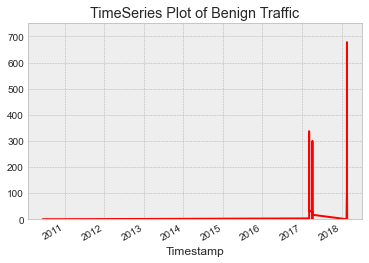

In [11]:
_= time['Benign'].plot(label='Benign', color='red', title='TimeSeries Plot of Benign Traffic', ylim=(0, 750))

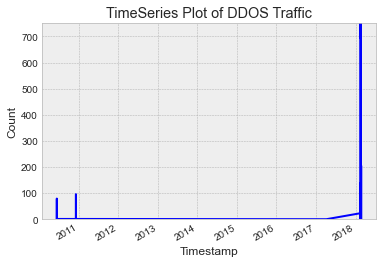

In [12]:
_= time['ddos'].plot(label='Ddos', color='blue', title='TimeSeries Plot of DDOS Traffic', ylim=(0, 750), ylabel='Count')

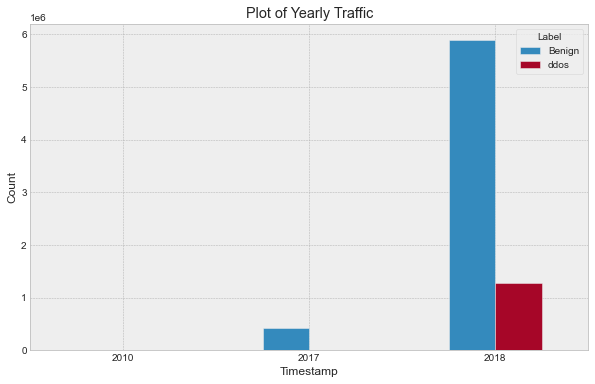

In [13]:
year= pd.crosstab(index=df['Timestamp'].dt.year, columns=df['Label'])
_= year.plot.bar(figsize=(10,6), rot=0, title='Plot of Yearly Traffic', ylabel='Count')

In [14]:
year

Label,Benign,ddos
Timestamp,,
2010,0,10798
2017,423931,0
2018,5898049,1283731


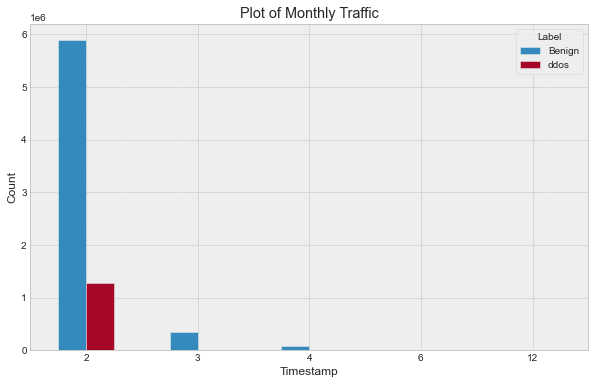

In [15]:
month= pd.crosstab(index=df['Timestamp'].dt.month, columns=df['Label'])
_= month.plot.bar(figsize=(10,6), rot=0, title='Plot of Monthly Traffic', ylabel='Count')

In [17]:
month

Label,Benign,ddos
Timestamp,,
2,5898049,1283731
3,352287,0
4,71644,0
6,0,1911
12,0,8887


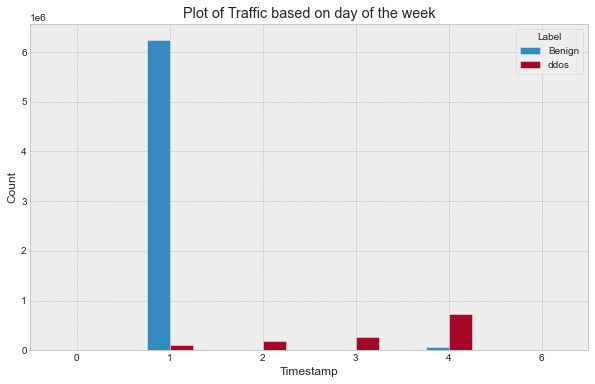

In [16]:
day= pd.crosstab(index=df['Timestamp'].dt.dayofweek, columns=df['Label'])
_= day.plot.bar(figsize=(10,6), rot=0, title='Plot of Traffic based on day of the week', ylabel='Count')

In [ ]:
day

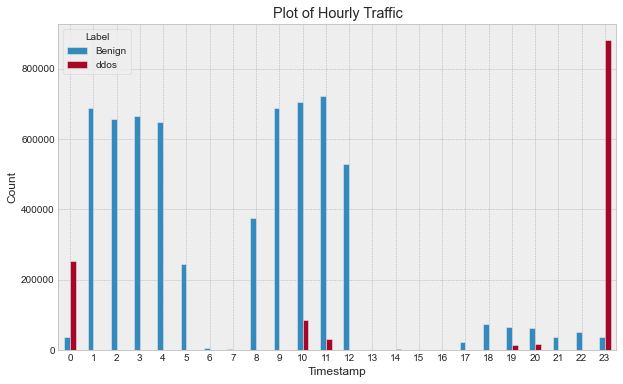

In [18]:
hour= pd.crosstab(index=df['Timestamp'].dt.time.apply(lambda x: x.hour), columns=df['Label'])
_= hour.plot.bar(figsize=(10,6), rot=0, title='Plot of Hourly Traffic', ylabel='Count')

In [19]:
hour

Label,Benign,ddos
Timestamp,,
0,39021,254713
1,688408,314
2,657810,65
3,665588,167
4,646866,225
5,244318,188
6,5007,96
7,2487,150
8,376214,89


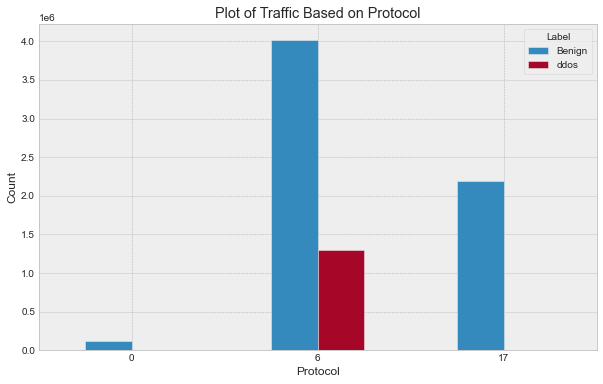

In [20]:
protocol= pd.crosstab(index=df['Protocol'], columns=df['Label'])
_= protocol.plot.bar(figsize=(10,6), rot=0, title='Plot of Traffic Based on Protocol', ylabel='Count')

In [21]:
protocol

Label,Benign,ddos
Protocol,,
0,115542,0
6,4020622,1293706
17,2185816,823


In [22]:
df_net= pd.concat([df["Src IP"], df["Src Port"], df["Dst IP"], df["Dst Port"]], axis=1)

In [23]:
source= df_net['Src IP'].str.split('.', expand=True)
source['Src IP Network']= source[0]+'.'+source[1]
source['Src IP Host']= source[2]+'.'+source[3]
source.drop(columns=[0, 1, 2, 3], inplace=True)

In [24]:
dest= df_net['Dst IP'].str.split('.', expand=True)
dest['Dst IP Network']= dest[0]+'.'+dest[1]
dest['Dst IP Host']= dest[2]+'.'+dest[3]
dest.drop(columns=[0, 1, 2, 3], inplace=True)

In [25]:
_= pd.concat([source, dest], axis=1)
df_net= pd.concat([df_net, _], axis=1)

<Figure size 432x288 with 0 Axes>

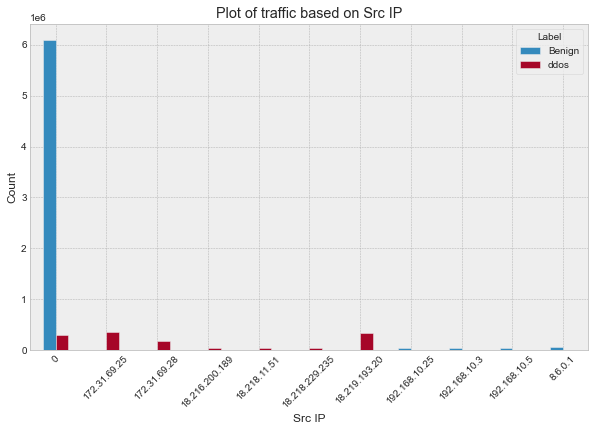

<Figure size 432x288 with 0 Axes>

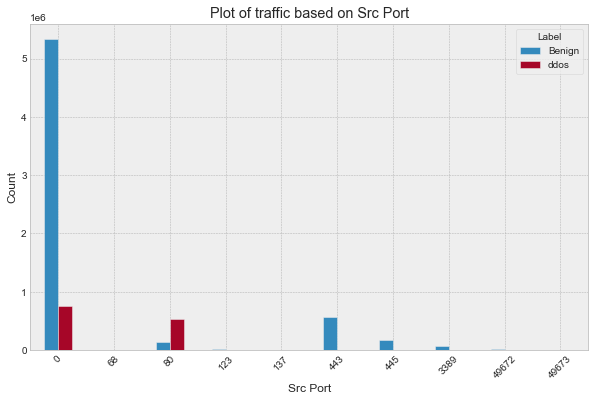

<Figure size 432x288 with 0 Axes>

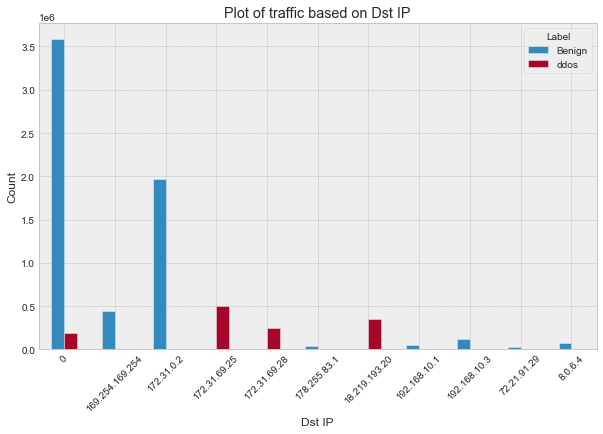

<Figure size 432x288 with 0 Axes>

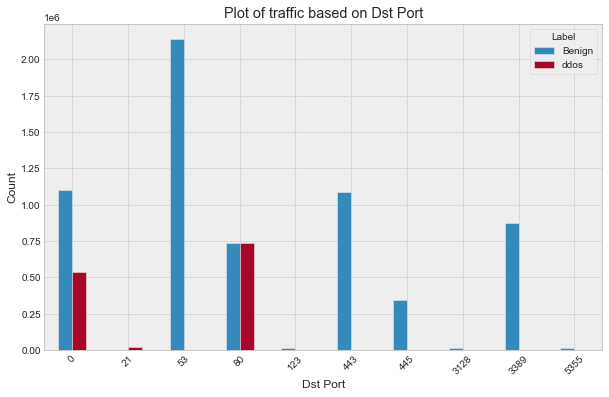

<Figure size 432x288 with 0 Axes>

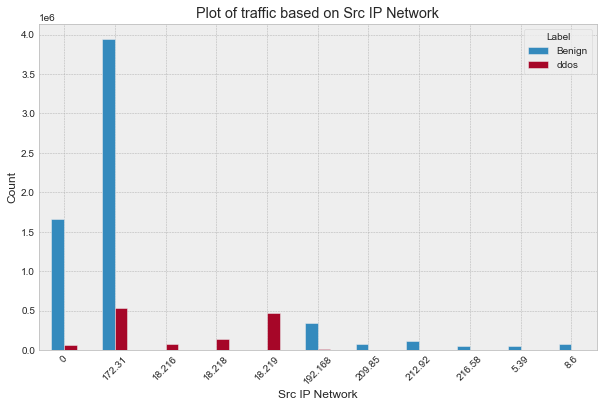

<Figure size 432x288 with 0 Axes>

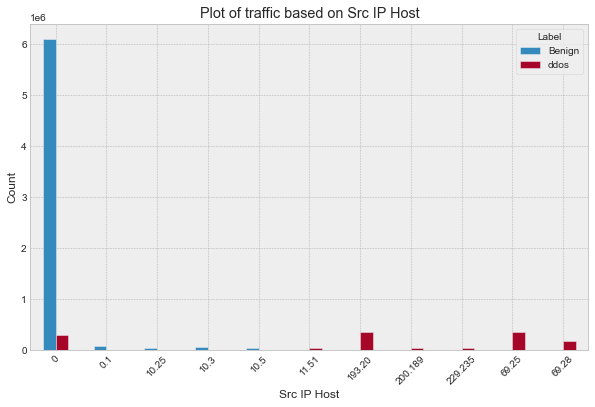

<Figure size 432x288 with 0 Axes>

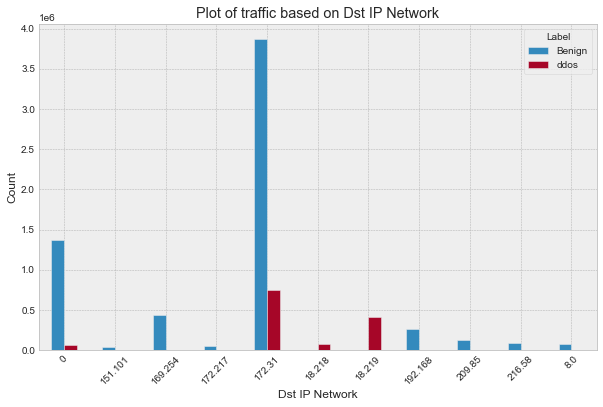

<Figure size 432x288 with 0 Axes>

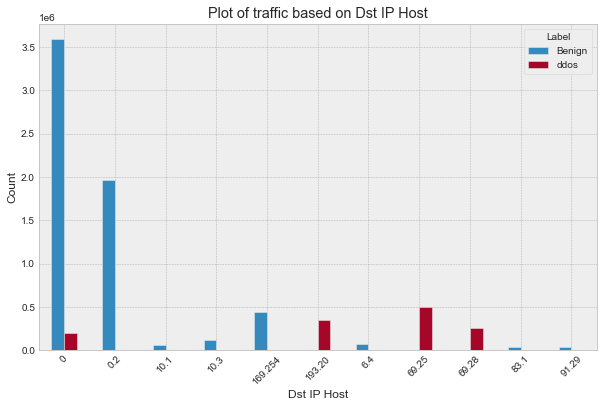

36827

In [26]:
for col in df_net.columns:
    plt.figure()
    chosen=list(df_net[col].value_counts()[0:10].index)
    _=df_net[col].apply(lambda x: x if x in chosen else 0)
    _= pd.crosstab(index=_, columns=df['Label'])
    _= _.plot.bar(figsize=(10,6), rot=45, title=f'Plot of traffic based on {col}', ylabel='Count')
    plt.show()
gc.collect()    

In [27]:
df.head()

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1739476,172.31.69.25-18.219.193.20-80-37882-6,18.219.193.20,37882,172.31.69.25,80,6,2018-02-16 23:27:29,8660,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00000,230.946884,8660.000000,0.000000,8660.0,8660.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,32,32,115.473442,115.473442,0.0,0.0,0.000,0.000000,0.000000,0,0,0,1,0,1.0,0.000000,0.00,0.000000,1,0,1,0,-1,225,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,1822666,172.31.69.28-18.219.9.1-80-63287-6,172.31.69.28,80,18.219.9.1,63287,6,2018-02-22 00:13:52,5829,4,3,935.0,298.0,935.0,0.0,233.75,467.5,298.0,0.0,99.333336,172.050385,211528.56250,1200.892090,971.500000,2104.125000,5260.0,7.0,5822.0,1940.666626,3119.411865,5541.0,46.0,5540.0,2770.0,3521.391846,5260.0,280.0,92,72,686.224060,514.668030,0.0,935.0,154.125,332.306427,110427.554688,1,0,0,0,1,0.0,176.142853,233.75,99.333336,4,935,3,298,-1,32768,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,905739,172.31.69.28-52.14.136.135-80-63095-6,52.14.136.135,63095,172.31.69.28,80,6,2018-02-22 00:14:02,3396,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00000,588.928162,3396.000000,0.000000,3396.0,3396.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,20,20,294.464081,294.464081,0.0,0.0,0.000,0.000000,0.000000,0,0,0,1,0,1.0,0.000000,0.00,0.000000,1,0,1,0,-1,32738,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,1143064,172.31.69.28-18.216.200.189-80-52341-6,18.216.200.189,52341,172.31.69.28,80,6,2018-02-22 00:28:04,2390,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00000,836.820068,2390.000000,0.000000,2390.0,2390.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,20,20,418.410034,418.410034,0.0,0.0,0.000,0.000000,0.000000,0,0,0,1,0,1.0,0.000000,0.00,0.000000,1,0,1,0,-1,32738,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,1934016,172.31.69.28-18.218.55.126-80-57459-6,172.31.69.28,80,18.218.55.126,57459,6,2018-02-22 00:19:45,17362,4,3,935.0,314.0,935.0,0.0,233.75,467.5,314.0,0.0,104.666664,181.287979,71938.71875,403.179352,2893.666748,6770.577637,16711.0,7.0,17355.0,5785.000000,9779.680664,17077.0,38.0,17074.0,8537.0,11559.781250,16711.0,363.0,92,72,230.388199,172.791153,0.0,935.0,156.125,333.342560,111117.265625,1,0,0,0,1,0.0,178.428574,233.75,104.666664,4,935,3,314,-1,32768,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [28]:
df_net.drop(columns=['Src IP','Src Port','Dst IP','Dst Port'], inplace=True)

In [29]:
df_net.head()

,Src IP Network,Src IP Host,Dst IP Network,Dst IP Host
0,18.219,193.20,172.31,69.25
1,172.31,69.28,18.219,9.1
2,52.14,136.135,172.31,69.28
3,18.216,200.189,172.31,69.28
4,172.31,69.28,18.218,55.126


In [30]:
def feature_eng(df, df_net):
    df= pd.get_dummies(df, columns=['Protocol'])
    df['Hour']= df['Timestamp'].dt.time.apply(lambda x: x.hour)
    df['Day']= df['Timestamp'].dt.dayofweek
    df['Month']= df['Timestamp'].dt.month
    df['Year']= df['Timestamp'].dt.year
    df= pd.concat([df, df_net], axis=1)
    df['Label'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)
    cat= np.concatenate((['Src IP', 'Dst IP'], df_net.columns), axis=0)
    le = LabelEncoder()
    df[cat] = df[cat].apply(le.fit_transform)
    return df.drop(columns=['Flow ID', 'Timestamp'])

In [31]:
df= feature_eng(df, df_net)

In [32]:
df.head()

,Unnamed: 0,Src IP,Src Port,Dst IP,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Protocol_0,Protocol_6,Protocol_17,Hour,Day,Month,Year,Src IP Network,Src IP Host,Dst IP Network,Dst IP Host
0,1739476,10334,37882,8059,80,8660,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00000,230.946884,8660.000000,0.000000,8660.0,8660.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,32,32,115.473442,115.473442,0.0,0.0,0.000,0.000000,0.000000,0,0,0,1,0,1.0,0.000000,0.00,0.000000,1,0,1,0,-1,225,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,23,4,2,2018,2702,11529,1545,22793
1,1822666,9183,80,9055,63287,5829,4,3,935.0,298.0,935.0,0.0,233.75,467.5,298.0,0.0,99.333336,172.050385,211528.56250,1200.892090,971.500000,2104.125000,5260.0,7.0,5822.0,1940.666626,3119.411865,5541.0,46.0,5540.0,2770.0,3521.391846,5260.0,280.0,92,72,686.224060,514.668030,0.0,935.0,154.125,332.306427,110427.554688,1,0,0,0,1,0.0,176.142853,233.75,99.333336,4,935,3,298,-1,32768,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0,3,2,2018,2299,24029,1863,25272
2,905739,24474,63095,8062,80,3396,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00000,588.928162,3396.000000,0.000000,3396.0,3396.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,20,20,294.464081,294.464081,0.0,0.0,0.000,0.000000,0.000000,0,0,0,1,0,1.0,0.000000,0.00,0.000000,1,0,1,0,-1,32738,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0,3,2,2018,6358,4997,1545,22799
3,1143064,10320,52341,8062,80,2390,1,1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00000,836.820068,2390.000000,0.000000,2390.0,2390.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,20,20,418.410034,418.410034,0.0,0.0,0.000,0.000000,0.000000,0,0,0,1,0,1.0,0.000000,0.00,0.000000,1,0,1,0,-1,32738,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0,3,2,2018,2699,12432,1545,22799
4,1934016,9183,80,9050,57459,17362,4,3,935.0,314.0,935.0,0.0,233.75,467.5,314.0,0.0,104.666664,181.287979,71938.71875,403.179352,2893.666748,6770.577637,16711.0,7.0,17355.0,5785.000000,9779.680664,17077.0,38.0,17074.0,8537.0,11559.781250,16711.0,363.0,92,72,230.388199,172.791153,0.0,935.0,156.125,333.342560,111117.265625,1,0,0,0,1,0.0,178.428574,233.75,104.666664,4,935,3,314,-1,32768,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0,3,2,2018,2299,24029,1862,20971


In [33]:
for col in df.columns:
    df[col]= df[col].astype('category')

In [38]:
X= df.drop(columns=['Label'])
y= df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [48]:
tree= DecisionTreeClassifier()
_ = tree.fit(X_train, y_train)
preds= tree.predict(X_test)
tree.score(X_test, y_test)

0.9999986870627098

In [50]:
confusion_matrix(y_test, preds)

array([[632197,      1],
       [     0, 129453]], dtype=int64)

In [51]:
f1_score(y_test, preds)

0.9999961376092574

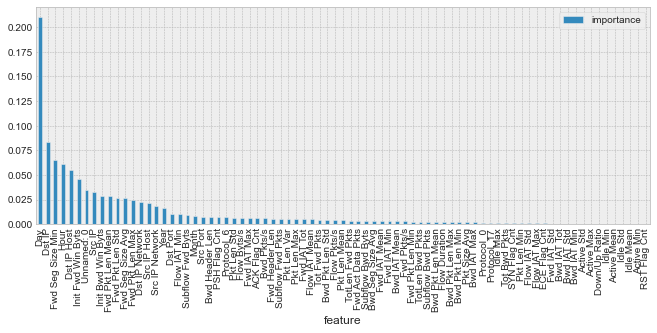

In [53]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)
forest_preds= rfc.predict(X_test)

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':X_train.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [54]:
confusion_matrix(y_test, forest_preds)

array([[632198,      0],
       [     0, 129453]], dtype=int64)

In [55]:
f1_score(y_test, forest_preds)

1.0

In [59]:
dtc = DecisionTreeClassifier()

rfe = RFE(dtc, n_features_to_select=40)
rfe = rfe.fit(X_train, y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

a = [i[0] for i in feature_map]
X_train_tr = X_train.iloc[:,a]
X_test_tr = X_test.iloc[:,a]

In [60]:
X_train_tr.head()

,Src Port,Dst IP,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0,Protocol_6,Protocol_17,Hour,Day,Month,Year,Src IP Network,Src IP Host,Dst IP Network,Dst IP Host
2609679,65201,8015,3389,3296582,9,7,1148.0,1581.0,677.0,0.0,127.555557,218.691055,1173.0,0.0,225.857147,430.098602,827.827148,4.853512,2.197721e+05,290766.531250,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0,10,1,2,2018,1473,8020,1545,22607
3130639,61776,7608,53,765,1,1,51.0,136.0,51.0,51.0,51.000000,0.000000,136.0,136.0,136.000000,0.000000,244444.437500,2614.379150,7.650000e+02,0.000000,8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,1,9,1,2,2018,2299,23119,1545,54
6793036,52259,646,443,160005,7,10,521.0,5168.0,201.0,0.0,74.428574,95.860764,1460.0,0.0,516.799988,663.638428,35555.140625,106.246681,1.000031e+04,13438.974609,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0,12,1,2,2018,2299,23876,216,8520
4315646,0,32481,0,112637588,3,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026634,5.631879e+07,33.941124,0,0.0,0.0,0.0,0.0,56318792.0,33.941124,56318816.0,56318768.0,1,0,0,2,1,2,2018,7402,1,5550,21436
4910600,6238,7807,3389,5114725,14,9,1460.0,1731.0,741.0,0.0,104.285713,195.090683,1179.0,0.0,192.333328,386.074463,623.884949,4.496820,2.324875e+05,268432.218750,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0,5,1,2,2018,3100,13318,1545,22284


In [74]:
models= [
         DecisionTreeClassifier(random_state=42),
         RandomForestClassifier(random_state=42),
         GradientBoostingClassifier(random_state=42)
        ]
for model in models:
    start= time()
    model.fit(X_train_tr, y_train)
    preds= model.predict(X_test_tr)
    print("="*50)
    print("Evaluation for", re.sub(r"\(.*", "", str(model)) ,"model:")
    print("Model accuracy= ", round(accuracy_score(y_test, preds)*100, 5), "%")
    print('Classification report: \n', classification_report(y_test, preds))
    print("Confusion matrix: \n", confusion_matrix(y_test, preds))
    end= time()
    print("Time taken to fit and predict model: ",round((end-start)/60,3), "min")
    print("="*50)

Evaluation for DecisionTreeClassifier model:
Model accuracy=  99.99987 %
Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    632198
           1       1.00      1.00      1.00    129453

    accuracy                           1.00    761651
   macro avg       1.00      1.00      1.00    761651
weighted avg       1.00      1.00      1.00    761651

Confusion matrix: 
 [[632197      1]
 [     0 129453]]
Time taken to fit and predict model:  1.133 min
Evaluation for RandomForestClassifier model:
Model accuracy=  100.0 %
Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    632198
           1       1.00      1.00      1.00    129453

    accuracy                           1.00    761651
   macro avg       1.00      1.00      1.00    761651
weighted avg       1.00      1.00      1.00    761651

Confusion matrix: 
 [[632198      0]
 [     0 1294